Test correlation between argument vectors of each verb and compare to verb sample size.

In [38]:
import numpy as np
from reach import Reach
import sklearn
import sklearn.preprocessing
import scipy.stats as stats
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [3]:
#pathnames
indexpath = './verbtrainingindex2.npy'
embeddingspath = './tulkens-embeddings/160/sonar-160.txt'
outputpath = './argv-variances'
figpath = './figures'

#import data
index = np.load(indexpath)
print('importing data...')
arg_data = Reach(embeddingspath, header=True)

importing data...
Vocab: 626711, Dim: 160


In [35]:
#output
outfile = open(outputpath, 'w')
outfile.write('verb\tN\tMean variance\n')

n_dim = 160
summary = np.array([0, 0.0])

#loop through verbs
print('looping through verbs')
for row in tqdm(index):
    if len(row[0]) >= 1:
        verb = row[0]
        samples = row[1]

        #container
        arg_vs = np.zeros((1, n_dim))
        samplesize = samples.shape[0]

        # load vectors into train and test collections
        for i in range(samplesize):
            sample = samples[i]
            # samples are of form holmatrixrow, argstring
            if sample[1] != '':
                # import vector
                arg_v = arg_data.vector(sample[1])

                #normalise vector
                scaler = sklearn.preprocessing.StandardScaler()
                arg_v = scaler.fit_transform(arg_v[:, np.newaxis])
                arg_v = np.squeeze(arg_v)

                #store argument vector
                if np.array_equal(arg_vs, np.zeros((1, n_dim))):
                    arg_vs = np.array([arg_v])
                else:
                    arg_vs = np.vstack([arg_vs, arg_v])
        
        #compute variances
        variances = list()
        for i in range(n_dim):
            variances.append(np.var(arg_vs[:,i]))
        outfile.write(verb+'\t'+str(samplesize)+'\t'+str(np.mean(variances)))
        for v in variances:
            outfile.write('\t'+str(v))
        outfile.write('\n')

        if np.array_equal(summary, np.zeros((1, 2))):
            summary = np.array([[samplesize, np.mean(variances)]])
        else:
            summary = np.vstack([summary, [samplesize, np.mean(variances)]])

outfile.close()


looping through verbs


In [37]:
sortedsummary = np.array(sorted(summary, key=lambda row: row[0]))

summary_trimmed = sortedsummary[2:]  #take out a few outliers

print(stats.pearsonr(summary_trimmed[:,0],summary_trimmed[:,1]))

(0.3663121431221859, 9.18576394370607e-20)


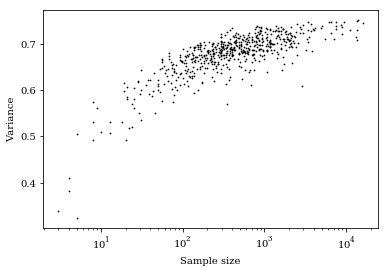

In [53]:
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman', 'Times', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Palatino', 'Charter', 'DejaVu Serif', 'serif']

plt.plot(summary_trimmed[:,0], summary_trimmed[:,1], 'k.', markersize=1.5)
plt.semilogx()
plt.xlabel('Sample size')
plt.ylabel('Variance')

plt.savefig(figpath+'/argv_correlation.eps', transparent=True)